In [3]:
#################################################################
# 0.  BASE 경로만 실제 폴더로 수정
#################################################################
from pathlib import Path
import pandas as pd

BASE = Path(r"C:\Users\Administrator\Desktop\0.졸업논문\1. Chapter 1\DATA\데이터 진짜 결과값\이거사용_DTM_news media text_70000_with pareto front\DTM_news media text_70000_with pareto front\Data 전처리")

# 1) 파일 읽기
words = pd.read_excel(BASE / 'DTM_Topic_Words_news.xlsx')          
dist  = pd.read_excel(BASE / 'DTM_Doc_Topic_Distribution_news.xlsx')

# ───────────────────────────────────────────────────────────────
#   1990–2024년 자료만 남기기
# ───────────────────────────────────────────────────────────────
dist = dist[(dist['year'] >= 1990) & (dist['year'] <= 2024)].copy()

# 2) 대표 단어 · β 통계
info = []
for topic, grp in (words.groupby(['Topic','Word'])['Weight']
                          .mean()
                          .reset_index()
                          .groupby('Topic')):
    g = grp.sort_values('Weight', ascending=False)
    info.append({
        'TopicID':       topic,
        'Rep word':      g.iloc[0]['Word'],
        'Max β_rep':     round(g.iloc[0]['Weight'], 4),
        'Mean β_top10':  round(g.head(10)['Weight'].mean(), 4),
        'Top-10 keywords': ', '.join(g.head(10)['Word'])
    })
rep_df = pd.DataFrame(info)

# 3) Peak yr / Peak % / Mean %
topic_cols = [c for c in dist.columns if c.startswith('DTM_Topic')]
yearly = dist.groupby('year')[topic_cols].mean()
yearly.columns = [int(c.replace('DTM_Topic','')) for c in yearly.columns]

summary = (pd.concat([
            yearly.idxmax().rename('Peak yr'),
            (yearly.max()*100).round(1).rename('Peak (%)'),
            (yearly.mean()*100).round(1).rename('Mean (%)')
          ], axis=1)
          .reset_index().rename(columns={'index':'TopicID'}))

# 4) 병합 + Label 자리
cols = ['TopicID', 'Label (ko/en)', 'Top-10 keywords', 'Rep word',
        'Peak yr', 'Peak (%)', 'Mean (%)', 'Max β_rep', 'Mean β_top10']

table = (summary.merge(rep_df, on='TopicID')
                 .assign(**{'Label (ko/en)': ''})  # <- 여기서 토픽 이름 직접 입력
                 [cols])

# 5) 저장 (이름에 기간을 붙여 구분해도 좋습니다)
out_path = BASE / 'Table1_News_DTM_1990-2024.xlsx'
table.to_excel(out_path, index=False)
print(f"✅  Table saved to: {out_path}")
print(table.head())


✅  Table saved to: C:\Users\Administrator\Desktop\0.졸업논문\1. Chapter 1\DATA\데이터 진짜 결과값\이거사용_DTM_news media text_70000_with pareto front\DTM_news media text_70000_with pareto front\Data 전처리\Table1_News_DTM_1990-2024.xlsx
   TopicID Label (ko/en)                                Top-10 keywords  \
0        0                자동차, 니콜라, 개발, 전기차, 트럭, 현대차, 하이브리드, 연료, 기술, 경차   
1        1                 사업, 재생에너지, 지역, 시설, 발전, 산업, 단지, 연료_전지, 건설, 울산   
2        2                    연료_전지, 개발, 기술, 연구, 전해, 촉매, 연료, 전지, 전기, 사용   
3        3                    사업, 두산, 연료_전지, 투자, 그룹, 기업, 시장, 회장, HD, 생산   
4        4                에너지, 개발, 기술, 발전, 청정, 녹색, 그린, 신재생에너지, 암모니아, 생산   

  Rep word  Peak yr  Peak (%)  Mean (%)  Max β_rep  Mean β_top10  
0      자동차     2000      24.5      11.5     0.0581        0.0200  
1       사업     2024      14.8       7.6     0.0297        0.0153  
2    연료_전지     1991      30.8      12.9     0.0298        0.0144  
3       사업     2010      16.6       8.6     0.0313        0.01

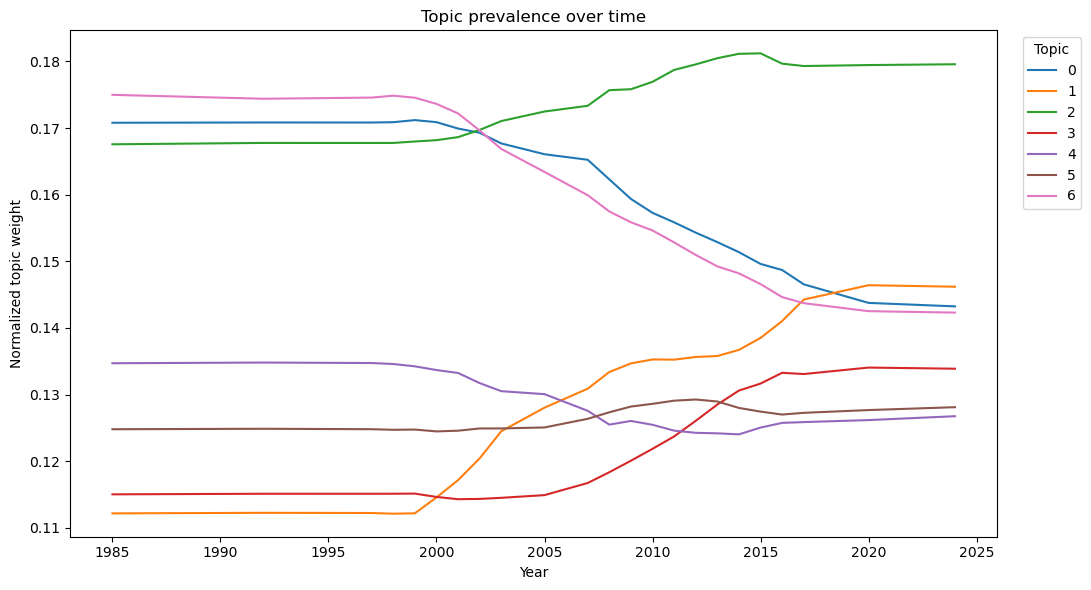

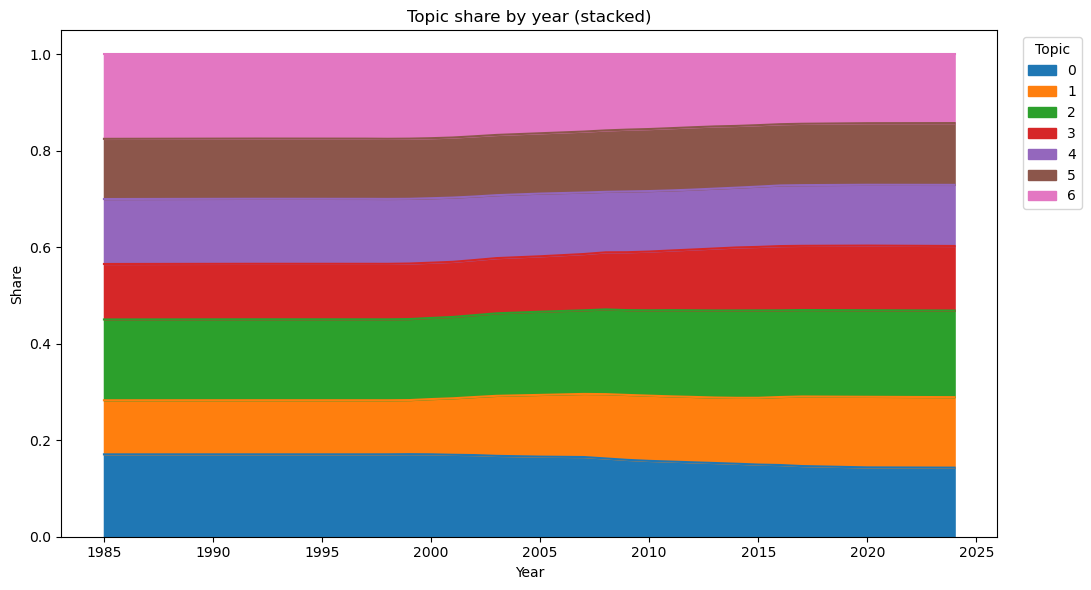

In [4]:
# ================================================================
# Topic-Year 가중치 변화 시각화 스크립트
# ================================================================
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 0) 파일 경로 설정
# ------------------------------------------------------------
BASE   = Path(r"C:\Users\Administrator\Desktop\0.졸업논문\1. Chapter 1\DATA\데이터 진짜 결과값\이거사용Again_DTM_Parliamentary_with pareto front - 5-40\데이터 전처리에 사용")
FNAME  = "Topic_Strength_Over_Time.xlsx"
SHEET  = "Sheet1"   # ← **따옴표 필수!**  (시트 번호면 0, 1 … 가능)

# ------------------------------------------------------------
# 1) 데이터 불러오기
# ------------------------------------------------------------
df = pd.read_excel(BASE / FNAME, sheet_name=SHEET)

# ------------------------------------------------------------
# 2) Year 컬럼 숫자화 (구간 → 대표 연도)
# ------------------------------------------------------------
def to_numeric_year(s: str) -> int:
    """'1989-1996' → 1992 / '2004-06' → 2005 / 단일연도 그대로"""
    s = re.sub(r"[^\d\-]", "", str(s))
    if "-" in s:
        a, b = s.split("-")
        if len(b) < len(a):              # '06' 보정 → '2006'
            b = a[:len(a) - len(b)] + b
        return (int(a) + int(b)) // 2
    return int(s)

df["Year_num"] = df["Year"].apply(to_numeric_year)

# ------------------------------------------------------------
# 3) 피벗: (Year × Topic) 테이블
# ------------------------------------------------------------
pivot = (df.pivot_table(index="Year_num",
                        columns="Topic",
                        values="Topic_Weight_Norm",
                        aggfunc="mean")
           .sort_index())

# ------------------------------------------------------------
# 4-A) 꺾은선 그래프
# ------------------------------------------------------------
plt.figure(figsize=(11, 6))
pivot.plot(ax=plt.gca())
plt.title("Topic prevalence over time")
plt.xlabel("Year")
plt.ylabel("Normalized topic weight")
plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4-B) 누적 면적 그래프
# ------------------------------------------------------------
plt.figure(figsize=(11, 6))
pivot.plot.area(ax=plt.gca())
plt.title("Topic share by year (stacked)")
plt.xlabel("Year")
plt.ylabel("Share")
plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# (선택) 3-년 이동평균 스무딩
# ------------------------------------------------------------
# smooth = pivot.rolling(window=3, center=True, min_periods=1).mean()
# plt.figure(figsize=(11,6))
# smooth.plot(ax=plt.gca())
# plt.title("Topic prevalence (3-year rolling mean)")
# plt.xlabel("Year")
# plt.ylabel("Smoothed share")
# plt.legend(title="Topic", bbox_to_anchor=(1.02,1), loc="upper left")
# plt.tight_layout()
# plt.show()


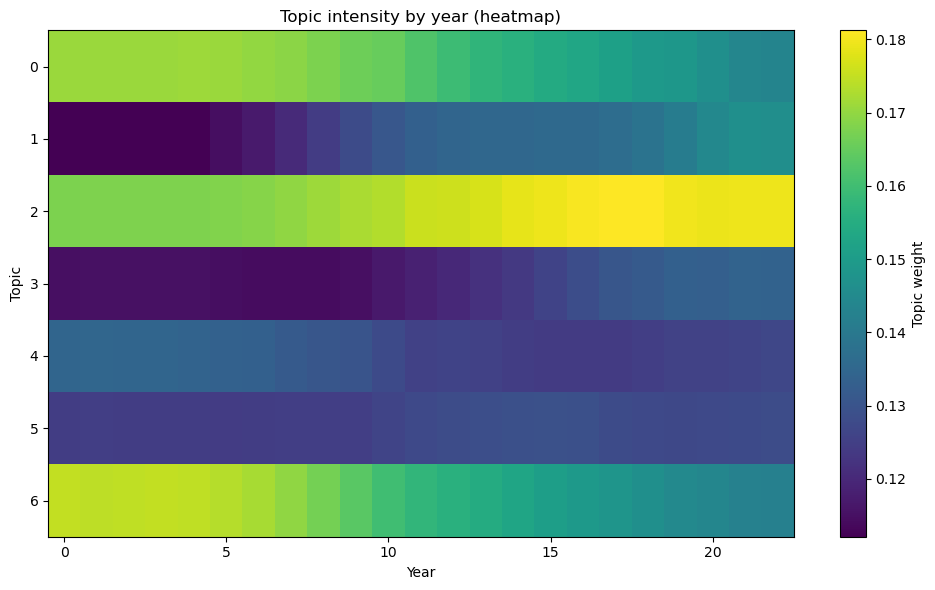

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6))
im = ax.imshow(pivot.T, aspect='auto', cmap='viridis',
               interpolation='nearest')
ax.set_yticks(range(len(pivot.columns)))
ax.set_yticklabels(pivot.columns)
ax.set_xlabel('Year')
ax.set_ylabel('Topic')
cbar = plt.colorbar(im, ax=ax, label='Topic weight')
plt.title('Topic intensity by year (heatmap)')
plt.tight_layout()
plt.show()


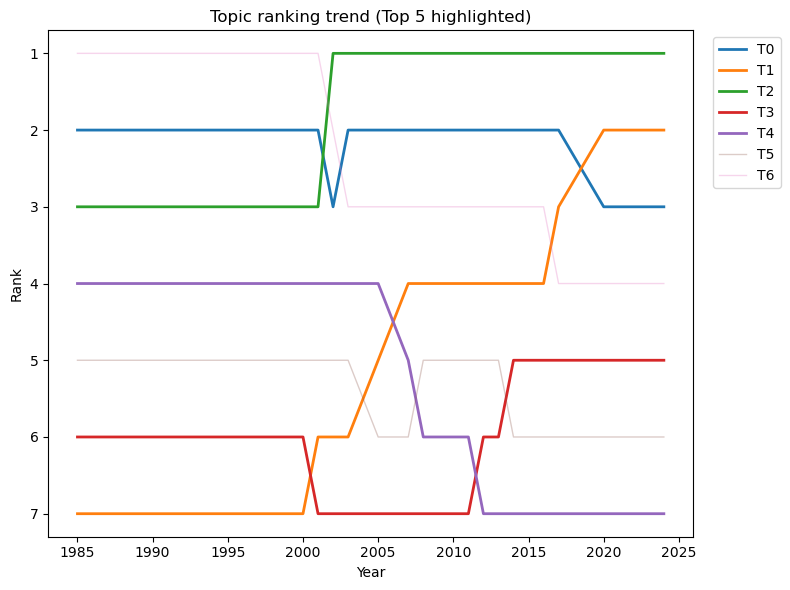

In [11]:
topN = 5
rank_df = pivot.rank(axis=1, ascending=False, method='first')

plt.figure(figsize=(8,6))
for t in rank_df.columns:
    plt.plot(rank_df.index, rank_df[t], label=f'T{t}', lw=2 if t < topN else 1,
             alpha=1 if t < topN else .3)
plt.gca().invert_yaxis()          # 1등을 위로
plt.yticks(range(1, len(pivot.columns)+1))
plt.xlabel('Year'); plt.ylabel('Rank')
plt.title(f'Topic ranking trend (Top {topN} highlighted)')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout(); plt.show()


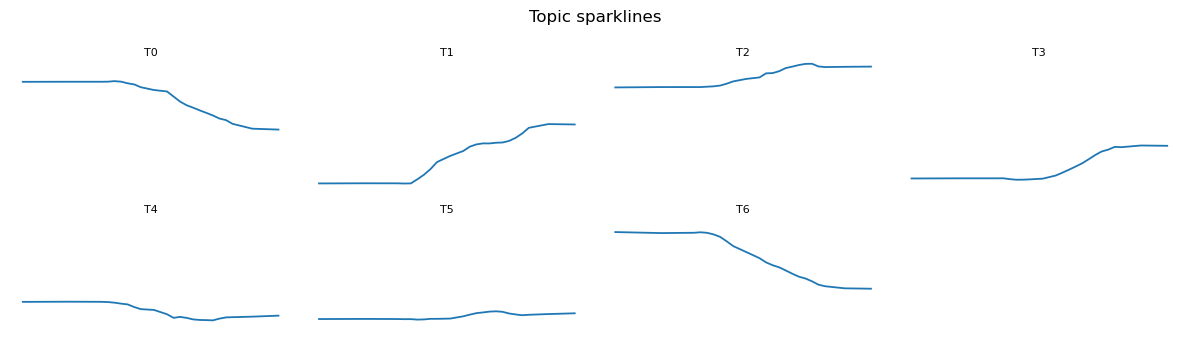

In [14]:
import math, matplotlib.pyplot as plt

n   = len(pivot.columns)       # 토픽 개수
cols = 4                       # 가로 그리드 수
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*1.8),
                         sharex=True, sharey=True)
axes = axes.flatten()

for i, topic in enumerate(pivot.columns):
    ax = axes[i]
    ax.plot(pivot.index, pivot[topic], lw=1.3)
    ax.set_title(f"T{topic}", fontsize=8, pad=2)
    ax.set_xticks([]); ax.set_yticks([])
    ax.spines[['top','right','left','bottom']].set_visible(False)

for j in range(i+1, rows*cols):
    axes[j].axis('off')        # 빈 칸 삭제

fig.suptitle("Topic sparklines", fontsize=12)
plt.tight_layout(); plt.show()


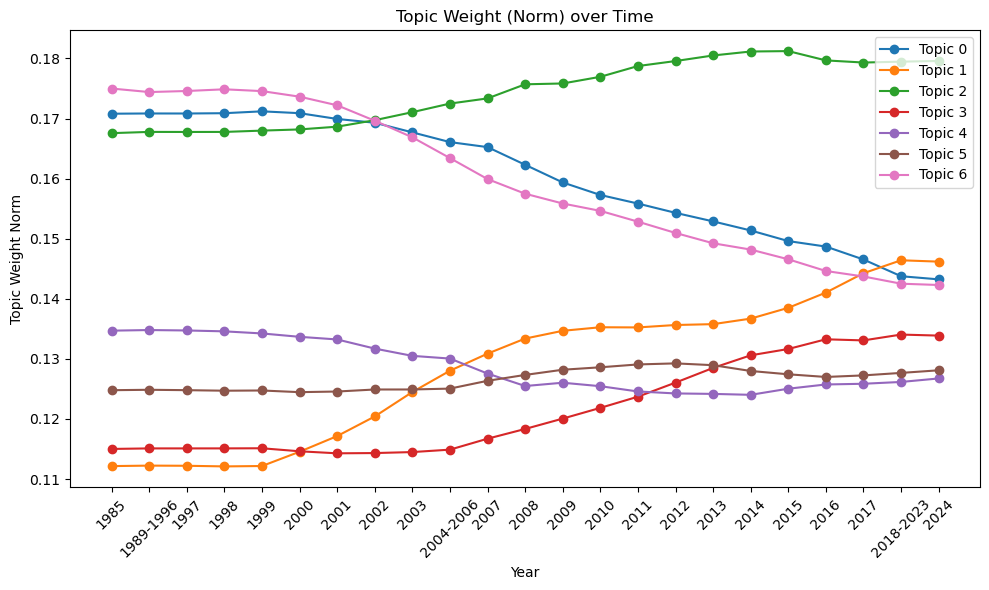

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 예시용 데이터프레임 예: df
# columns = ['Topic', 'Year', 'Topic_Weight_Sum', 'Topic_Weight_Norm']
# 가정: 1985, 1989-1996... 등 'Year'가 문자열인 경우를 처리하기 위해 우선 문자열로 저장된 상태라고 가정

# 1) 'Year' 열을 x축 기준으로, 'Topic'별 'Topic_Weight_Norm'의 변화를 라인 차트로 그리고 싶다면?
#    먼저 연도로 Pivot을 합니다.
df_pivot = df.pivot(index='Year', columns='Topic', values='Topic_Weight_Norm')

# 2) Plot
plt.figure(figsize=(10,6))
for col in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[col], label=f'Topic {col}', marker='o')
    
plt.title('Topic Weight (Norm) over Time')
plt.xlabel('Year')
plt.ylabel('Topic Weight Norm')
plt.legend()
plt.xticks(rotation=45)  # 연도 텍스트가 겹치는 경우 회전
plt.tight_layout()
plt.show()


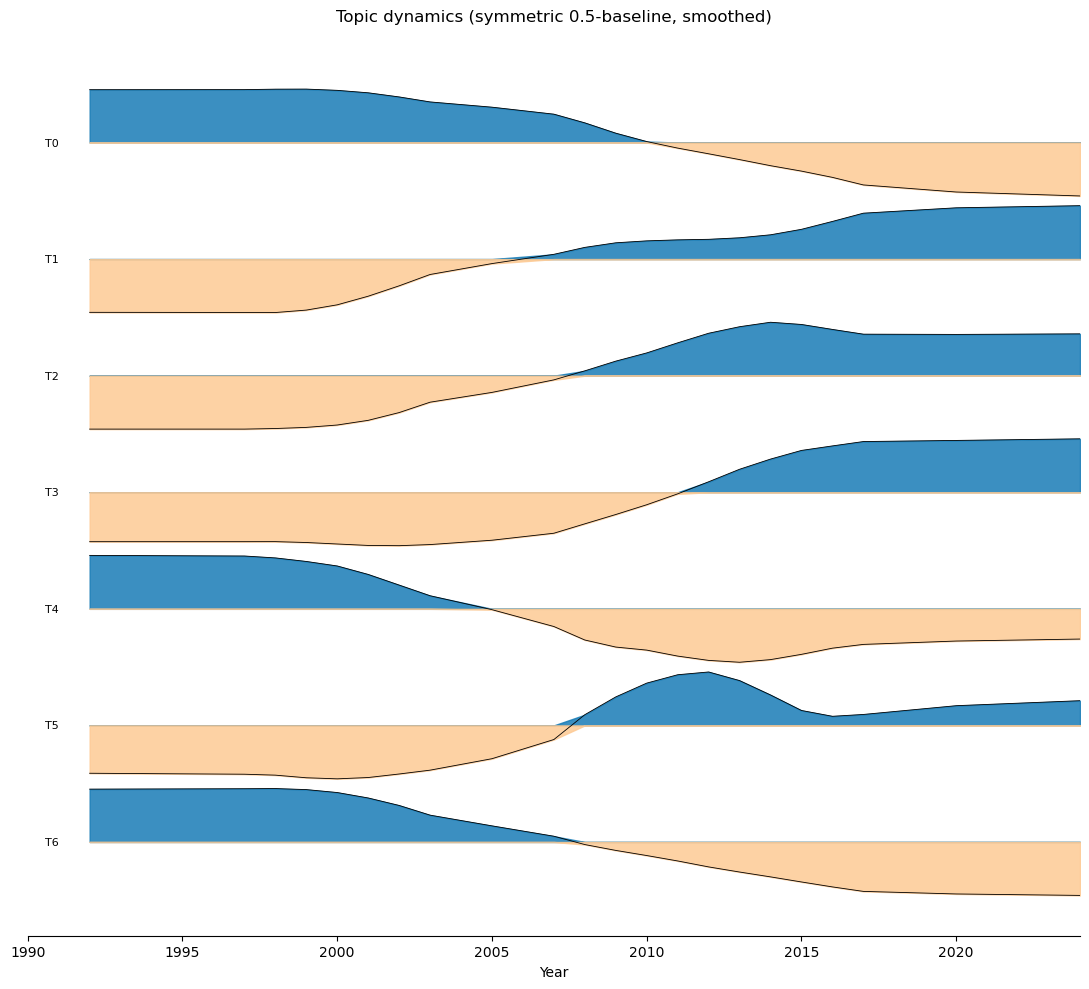

In [31]:
# ================================================================
# Symmetric ridge plot : ↑ 늘었다 · ↓ 줄었다  (1990–2024, smoothed)
# ================================================================
from pathlib import Path
import re, pandas as pd, numpy as np, matplotlib.pyplot as plt

# ------------------------------------------------------------ ① 경로
BASE  = Path(r"C:\Users\Administrator\Desktop\0.졸업논문\1. Chapter 1\DATA\데이터 진짜 결과값\이거사용Again_DTM_Parliamentary_with pareto front - 5-40\데이터 전처리에 사용")
FILE  = "Topic_Strength_Over_Time.xlsx"
SHEET = "Sheet1"

# ------------------------------------------------------------ ② 데이터 읽기 + 연도 숫자화
df = pd.read_excel(BASE / FILE, sheet_name=SHEET)

def to_year(s):
    s = re.sub(r"[^\d\-]", "", str(s))
    if "-" in s:
        a, b = s.split("-")
        if len(b) < len(a): b = a[:len(a)-len(b)] + b
        return (int(a) + int(b)) // 2
    return int(s)

df["Year_num"] = df["Year"].apply(to_year)

# ------------------------------------------------------------ ③ 피벗 & 연도 필터
pv = (df.pivot_table(index="Year_num",
                     columns="Topic",
                     values="Topic_Weight_Norm",
                     aggfunc="mean")
        .sort_index()) \
        .loc[1990:2024]

# 3-년 이동평균 → 부드럽게
pv = pv.rolling(window=3, center=True, min_periods=1).mean()

years, topics = pv.index.values, pv.columns

# ------------------------------------------------------------ ④ 0–1 정규화 후 0.5 기준 대칭화
normed   = (pv - pv.min()) / (pv.max() - pv.min())      # 0~1
symm     = normed - 0.5                                 # −0.5 ~ +0.5
ampl     = 1.1                                          # 세로 확대(가시성)
offset   = 1.2                                          # 곡선 간 간격
c_up     = plt.cm.PuBu    # 증가(위)
c_down   = plt.cm.OrRd_r  # 감소(아래)

fig, ax = plt.subplots(figsize=(11, 10))

for i, t in enumerate(topics[::-1]):                    # 위쪽이 T0
    y = (symm[t] * ampl).values
    base = i * offset
    # 증가 구간
    ax.fill_between(years, base, np.maximum(0, y)+base,
                    color=c_up(.7), alpha=.85)
    # 감소 구간
    ax.fill_between(years, base, np.minimum(0, y)+base,
                    color=c_down(.7), alpha=.85)
    ax.plot(years, y + base, color='k', lw=.6)
    ax.text(years[0]-1, base, f"T{t}", ha='right', va='center', size=8)

# ------------------------------------------------------------ ⑤ 미관 설정
ax.set_xlabel("Year"); ax.set_yticks([])
ax.set_xlim(1990, 2024)
ax.set_title("Topic dynamics (symmetric 0.5-baseline, smoothed)", pad=20)
ax.spines[['left','right','top']].set_visible(False)
plt.tight_layout(); plt.show()


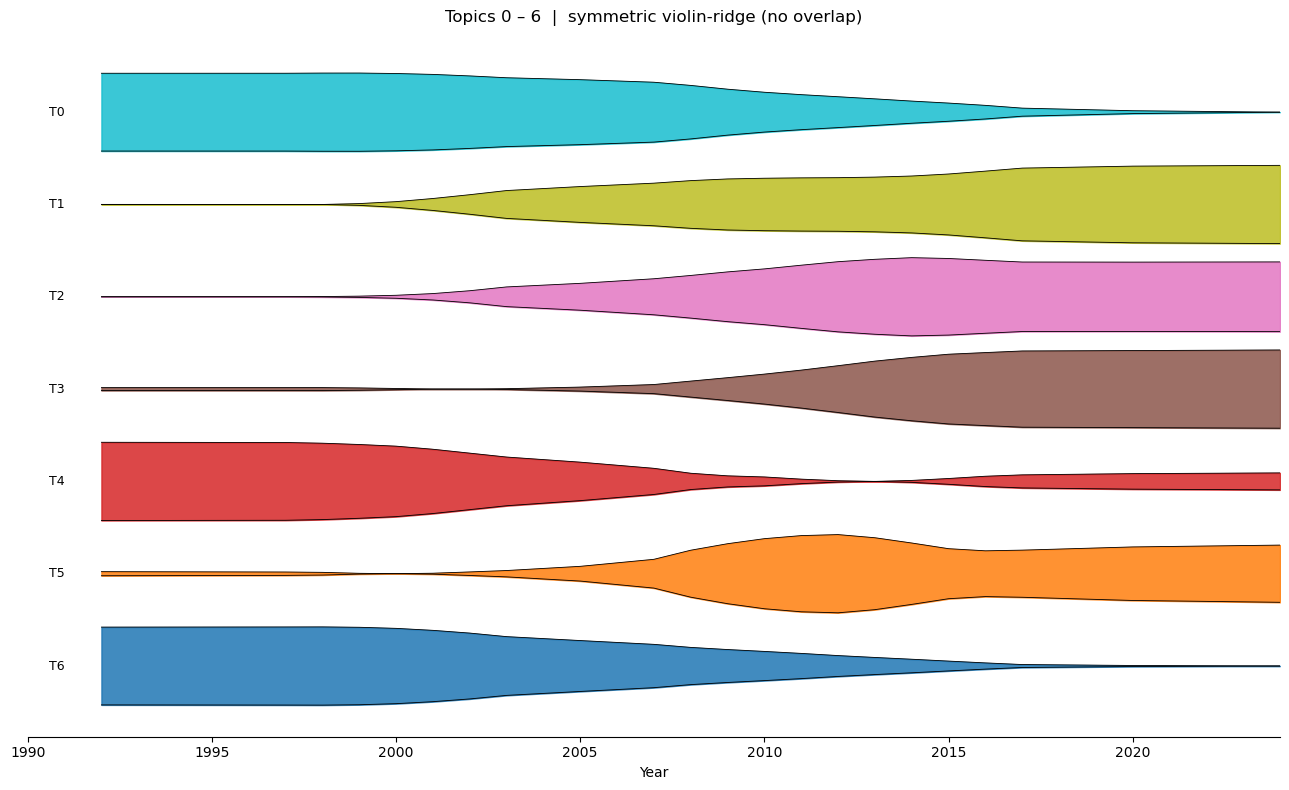

In [ ]:
# ================================================================
# Symmetric “violin-ridge” ─ topic 0 ~ 6, 절대 겹침 없음
# ================================================================
from pathlib import Path
import re, pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib import cm

# ---------- 1. 경로·파라미터 ----------
BASE  = Path(r"C:\Users\Administrator\Desktop\0.졸업논문\1. Chapter 1\DATA\데이터 진짜 결과값\이거사용Again_DTM_Parliamentary_with pareto front - 5-40\데이터 전처리에 사용")
FILE  = "Topic_Strength_Over_Time.xlsx"
SHEET = "Sheet1"

YEAR_MIN, YEAR_MAX = 1990, 2024


AMPLIFY   = 2.5        # 1.5 → 4  (세로 폭 크게)
BUMP_EXP  = 0.5        # 0.5 → 2.2 (뾰족함 과장)
SMOOTH_WIN = 1         # 이동평균 창 (1 = 원본)
GAUSS_SIGMA = 3.7      # 가우시안 필터 σ (높을수록 부드러움)
MARGIN_RATIO = 0.18    # 줄 간 여유 (15 %)

# ---------- 2. 데이터 ----------
df = pd.read_excel(BASE / FILE, sheet_name=SHEET)

def to_year(s):
    s = re.sub(r"[^\d\-]", "", str(s))
    if "-" in s:
        a, b = s.split("-")
        if len(b) < len(a): b = a[:len(a)-len(b)] + b
        return (int(a)+int(b))//2
    return int(s)

df["Year_num"] = df["Year"].apply(to_year)

pv = (df.pivot_table(index="Year_num",
                     columns="Topic",
                     values="Topic_Weight_Norm",
                     aggfunc="mean")
        .sort_index()) \
        .loc[YEAR_MIN:YEAR_MAX]

topics = [t for t in range(7) if t in pv.columns]  # 0 ~ 6 그대로

pv = pv[topics].rolling(window=3, center=True, min_periods=1).mean()

# 0–1 정규화 + 과장
amp = (pv - pv.min()) / (pv.max() - pv.min()) * AMPLIFY
years = amp.index.values

# ---------- 3. 각 토픽 줄 높이 & base 위치 ----------
height = amp.max() * 2                 # Series: 토픽별 전체 높이
base   = {}                            # 토픽 → 베이스 y 좌표
acc    = 0
for t in reversed(topics):             # 위에 올 토픽부터 누적
    base[t] = acc
    acc += height[t] * (1 + MARGIN_RATIO)

# ---------- 4. 팔레트 ----------
palette = cm.get_cmap('tab10', len(topics))

# ---------- 5. 플롯 ----------
fig, ax = plt.subplots(figsize=(13, 8))

for idx, t in enumerate(reversed(topics)):         # 6이 위, 0이 아래
    y     = amp[t].values
    b     = base[t]
    color = palette(idx)

    ax.fill_between(years, b - y, b + y,
                    color=color, alpha=.85)
    ax.plot(years, b + y, color='k', lw=.6)
    ax.plot(years, b - y, color='k', lw=.6)
    ax.text(years[0]-1, b, f"T{t}", ha='right', va='center', fontsize=9)

# ---------- 6. 꾸미기 ----------
ax.set_xlim(YEAR_MIN, YEAR_MAX)
ax.set_xlabel("Year")
ax.set_yticks([])
ax.set_title("Topics 0 – 6  |  symmetric violin-ridge (no overlap)", pad=14)
ax.spines[['left', 'right', 'top']].set_visible(False)
plt.tight_layout(); plt.show()


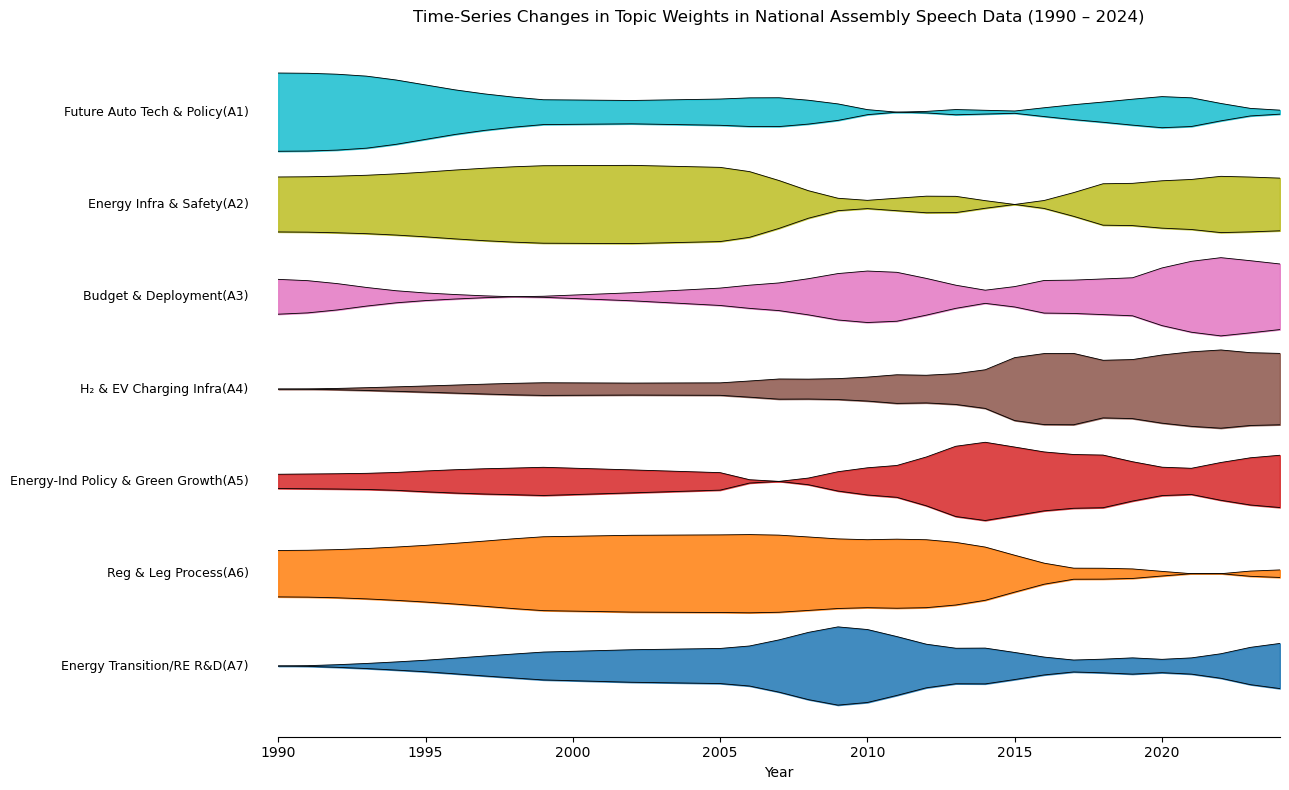

In [ ]:
#이거 사용함함 ================================================================
# Symmetric “violin-ridge” ─ Time-Series Changes in Topic Weights
#             in National Assembly Speech Data (1990 – 2024)
# ================================================================
from pathlib import Path
import re, pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib import cm

# ---------- 1. 경로·파라미터 ----------
BASE  = Path(r"C:\Users\Administrator\Desktop\0.졸업논문\1. Chapter 1\DATA\데이터 진짜 결과값\이거사용_DTM_news media text_70000_with pareto front\DTM_news media text_70000_with pareto front\Data 전처리")
FILE  = "Topic_Strength_Over_Time.xlsx"
SHEET = "Sheet1"

YEAR_MIN, YEAR_MAX = 1990, 2024

AMPLIFY     = 2.5     # 세로 폭
BUMP_EXP    = 0.5     # 뾰족함 과장 (현재 코드에선 미사용)
SMOOTH_WIN  = 1       # 이동평균 창 (1 = 원본)
GAUSS_SIGMA = 3.7     # 가우시안 필터 σ (현재 코드에선 미사용)
MARGIN_RATIO = 0.18   # 토픽 간 간격 (15 %)

# ---------- 2. 토픽 라벨 ----------
label_map = {
    0: "Future Auto Tech & Policy(A1)",
    1: "Energy Infra & Safety(A2)",
    2: "Budget & Deployment(A3)",
    3: "H₂ & EV Charging Infra(A4)",
    4: "Energy-Ind Policy & Green Growth(A5)",
    5: "Reg & Leg Process(A6)",
    6: "Energy Transition/RE R&D(A7)",
    7: "Future Auto Tech & Policy(A1)",
    8: "Energy Infra & Safety(A2)",
    9: "Budget & Deployment(A3)",
    10: "H₂ & EV Charging Infra(A4)",
}

# ---------- 3. 데이터 로드 ----------
df = pd.read_excel(BASE / FILE, sheet_name=SHEET)

def to_year(s: str) -> int:
    """‘1990–1991’ 같은 범위는 중간값으로, 그 외엔 정수 연도로 변환"""
    s = re.sub(r"[^\d\-]", "", str(s))
    if "-" in s:
        a, b = s.split("-")
        if len(b) < len(a):               # ‘1990–91’ 같은 형식 보정
            b = a[:len(a)-len(b)] + b
        return (int(a) + int(b)) // 2
    return int(s)

df["Year_num"] = df["Year"].apply(to_year)

pv = (
    df.pivot_table(index="Year_num",
                   columns="Topic",
                   values="Topic_Weight_Norm",
                   aggfunc="mean")
      .sort_index()
).loc[YEAR_MIN:YEAR_MAX]

topics = [t for t in range(7) if t in pv.columns]   # 0 – 6 그대로 사용
pv = pv[topics].rolling(window=3, center=True, min_periods=1).mean()

# 0–1 정규화 뒤 과장
amp   = (pv - pv.min()) / (pv.max() - pv.min()) * AMPLIFY
years = amp.index.values

# ---------- 4. 각 토픽 베이스 높이 계산 ----------
height = amp.max() * 2            # 토픽별 전체 높이
base   = {}
acc    = 0
for t in reversed(topics):        # 위에서부터 누적
    base[t] = acc
    acc += height[t] * (1 + MARGIN_RATIO)

# ---------- 5. 팔레트 ----------
palette = cm.get_cmap('tab10', len(topics))

# ---------- 6. 플롯 ----------
fig, ax = plt.subplots(figsize=(13, 8))

for idx, t in enumerate(reversed(topics)):          # 6이 위, 0이 아래
    y     = amp[t].values
    b     = base[t]
    color = palette(idx)

    ax.fill_between(years, b - y, b + y,
                    color=color, alpha=.85)
    ax.plot(years, b + y, color='k', lw=.6)
    ax.plot(years, b - y, color='k', lw=.6)
    ax.text(years[0] - 1, b, label_map[t],
            ha='right', va='center', fontsize=9)

# ---------- 7. 꾸미기 ----------
ax.set_xlim(YEAR_MIN, YEAR_MAX)
ax.set_xlabel("Year")
ax.set_yticks([])
ax.set_title(
    "Time-Series Changes in Topic Weights in National Assembly Speech Data (1990 – 2024)",
    pad=14
)
ax.spines[['left', 'right', 'top']].set_visible(False)
plt.tight_layout()
# ---------- 6. 그림 저장 ----------
plt.savefig("NationalAssembly_TopicWeights_1990-2024.png", dpi=300)
plt.show()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14408\31480614.py:56: RuntimeWarning: invalid value encountered in sqrt
  0.5 + (norm.values - 0.5)**BUMP_EXP,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14408\31480614.py:57: RuntimeWarning: invalid value encountered in sqrt
  0.5 - (0.5 - norm.values)**BUMP_EXP)


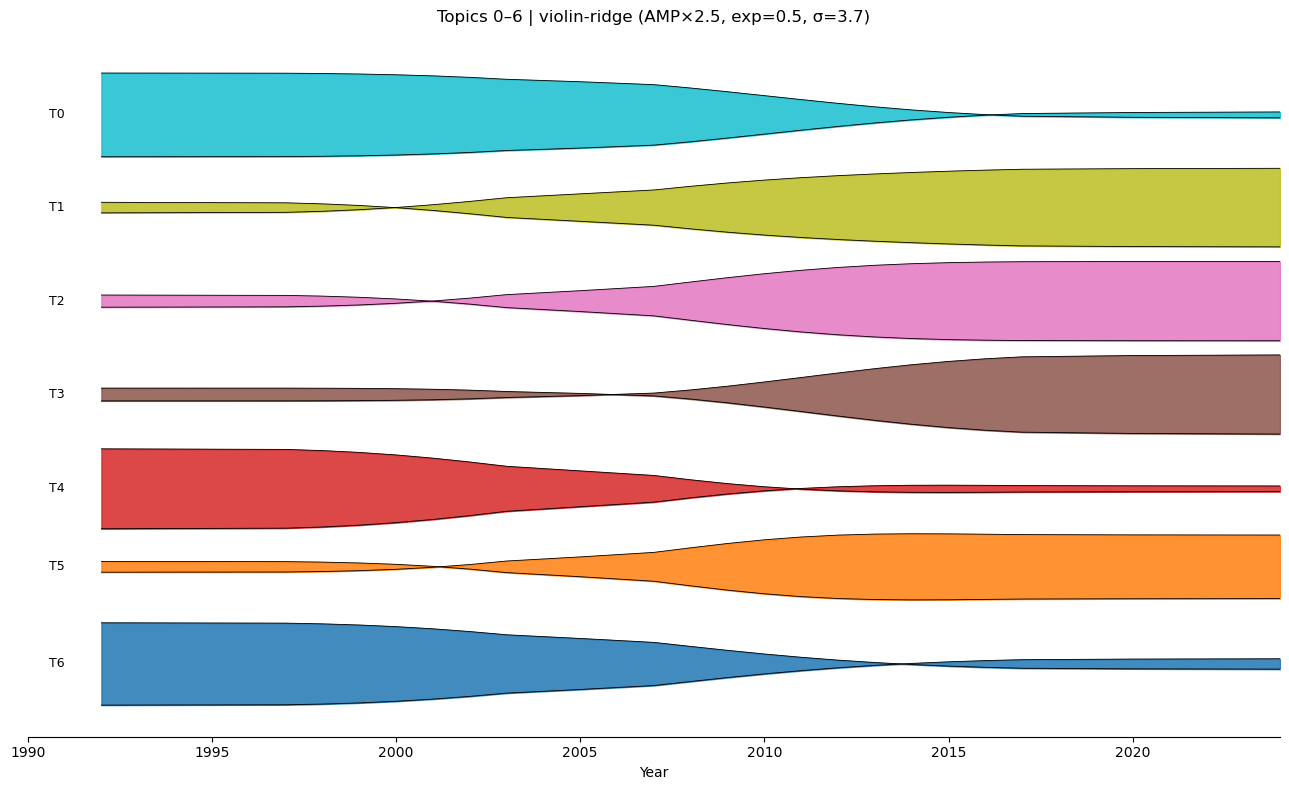

In [3]:
# ================================================================
# Violin-ridge (topics 0–6) ─ no overlap, smooth “curvy” version
#   • x-axis = Year (1990-2024)
#   • y-axis = Topic 0 → 6  (고유 색상)
#   • AMPLIFY × BUMP_EXP 로 변동폭 과장
#   • σ(GAUSS_SIGMA) 로 곡선을 부드럽게
# ================================================================
from pathlib import Path
import re, pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib import cm
from scipy.ndimage import gaussian_filter1d    # ← 곡선 부드럽힘

# ------------------ 1. 하이레벨 파라미터 ------------------
BASE   = Path(r"C:\Users\Administrator\Desktop\0.졸업논문\1. Chapter 1\DATA\데이터 진짜 결과값\이거사용Again_DTM_Parliamentary_with pareto front - 5-40\데이터 전처리에 사용")
FILE   = "Topic_Strength_Over_Time.xlsx"
SHEET  = "Sheet1"

YEAR_MIN, YEAR_MAX = 1990, 2024
TOPICS            = list(range(7))     # 0–6 순서 그대로

# “울퉁불퉁” 과장 정도
AMPLIFY   = 2.5        # 1.5 → 4  (세로 폭 크게)
BUMP_EXP  = 0.5        # 0.5 → 2.2 (뾰족함 과장)
SMOOTH_WIN = 1         # 이동평균 창 (1 = 원본)
GAUSS_SIGMA = 3.7      # 가우시안 필터 σ (높을수록 부드러움)
MARGIN_RATIO = 0.18    # 줄 간 여유 (15 %)

# ------------------ 2. 데이터 읽기 & 전처리 ------------------
df = pd.read_excel(BASE / FILE, sheet_name=SHEET)

def to_year(s: str) -> int:
    s = re.sub(r"[^\d\-]", "", str(s))
    if "-" in s:
        a, b = s.split("-")
        if len(b) < len(a):            # '06'  → 2006
            b = a[:len(a) - len(b)] + b
        return (int(a) + int(b)) // 2
    return int(s)

df["Year_num"] = df["Year"].apply(to_year)

pv = (df.pivot_table(index="Year_num",
                     columns="Topic",
                     values="Topic_Weight_Norm",
                     aggfunc="mean")
        .sort_index()) \
        .loc[YEAR_MIN:YEAR_MAX, TOPICS]

# ------------------ 3. 스무딩 & 정규화 ------------------
pv = pv.rolling(window=SMOOTH_WIN, center=True, min_periods=1).mean()

norm = (pv - pv.min()) / (pv.max() - pv.min())          # 0–1

# 비선형 과장 (0.5 기준)
bump_arr = np.where(norm.values >= 0.5,
                    0.5 + (norm.values - 0.5)**BUMP_EXP,
                    0.5 - (0.5 - norm.values)**BUMP_EXP)

bump = pd.DataFrame(bump_arr, index=norm.index, columns=norm.columns)
amp  = bump * AMPLIFY                                   # 세로 확대

# 가우시안 필터로 가장자리 둥글게
amp = amp.apply(lambda col: gaussian_filter1d(col, sigma=GAUSS_SIGMA))

years = amp.index.values

# ------------------ 4. 줄 높이 계산 ------------------
height = amp.max() * 2                                  # 토픽별 전체 높이
base = {}
acc  = 0
for t in reversed(TOPICS):
    base[t] = acc
    acc += height[t] * (1 + MARGIN_RATIO)

# ------------------ 5. 그림 ------------------
palette = cm.get_cmap('tab10', len(TOPICS))
fig, ax = plt.subplots(figsize=(13, 8))

for idx, t in enumerate(reversed(TOPICS)):
    y     = amp[t].values
    b     = base[t]
    color = palette(idx)

    ax.fill_between(years, b - y, b + y, color=color, alpha=.85)
    ax.plot(years, b + y, color='k', lw=.6)
    ax.plot(years, b - y, color='k', lw=.6)
    ax.text(years[0] - 1, b, f"T{t}", ha='right', va='center', size=9)

# ------------------ 6. 레이아웃 ------------------
ax.set_xlim(YEAR_MIN, YEAR_MAX)
ax.set_xlabel("Year")
ax.set_yticks([])
ax.set_title(
    f"Topics 0–6 | violin-ridge (AMP×{AMPLIFY}, exp={BUMP_EXP}, σ={GAUSS_SIGMA})",
    pad=14
)
ax.spines[['left', 'right', 'top']].set_visible(False)
plt.tight_layout()
plt.show()


In [23]:
print(pivot.index[:5])   # → [1985, 1986, …]  (연도)
print(pivot.columns[:5]) # → [0, 1, 2, …]     (토픽)

# ── 이 구조가 맞다면 JoyPy에 넘겼을 때 x=Year, y=Topic 이 정상 ──


Index([1985, 1992, 1997, 1998, 1999], dtype='int64', name='Year_num')
Index([0, 1, 2, 3, 4], dtype='int64', name='Topic')


In [17]:
import plotly.express as px
fig = px.line(pivot, x=pivot.index, y=pivot.columns,
              labels={'value':'Share', 'variable':'Topic'},
              title='Interactive topic trends')
fig.update_xaxes(dtick=5)      # 5년 간격 눈금
fig.show()
